In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os
import sys

# local imports 
import filters
import pore_c_utils as pcu

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Loading Data

In [3]:
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
cell = "NlaIII_run07"

df = pcu.loadContactTable(dirpath, cell)
print(f"{df.shape=}")
totalRecords = df.shape[0]
print(f"{totalRecords=}")
df.head()

df.shape=(10525887, 38)
totalRecords=10525887


,read_name,read_length,read_idx,contact_is_direct,contact_is_cis,contact_read_distance,contact_genome_distance,contact_fragment_adjacent,contact_fragment_distance,haplotype_pair_type,...,align2_strand,align2_mapping_quality,align2_align_score,align2_align_base_qscore,align2_phase_set,align2_haplotype,align2_fragment_id,align2_fragment_start,align2_fragment_end,batch_id
0,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,True,True,13,-2205,True,0,unphased,...,True,38,216,14,0,-1,7450888,34492235,34499305,batch15
1,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,False,True,199,18,True,0,unphased,...,True,121,166,13,0,-1,7450888,34492235,34499305,batch15
2,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,False,True,432,-856,True,0,unphased,...,True,14,86,22,0,-1,7450888,34492235,34499305,batch15
3,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,True,True,-58,1978,True,0,unphased,...,True,121,166,13,0,-1,7450888,34492235,34499305,batch15
4,000188c4-51f3-4a10-9bce-f328c3594118,849,22724,False,True,175,1104,True,0,unphased,...,True,14,86,22,0,-1,7450888,34492235,34499305,batch15


# Summary Statistics

In [4]:
res = pcu.getSummary(df)
pcu.printSummary(res)

Total Reads 557134 (1.000)
Singletons 145909 (0.262)
Pairs 0 (0.000)
Multiway 411225 (0.738)
-- -- --
Total Contacts 10525887.0 (1.000)
cis Contacts 7456892.0 (0.708)
trans Contacts 3068995.0 (0.292)
Cis/Trans Ratio 2.4297504557680933 (0.000)
-- -- --
Total Contacts 10525887 (1.000)
Intra- Contacts 7456892 (0.708)
Inter- Contacts 3068995 (0.292)
-- -- --
Total Contacts 10525887 (1.000)
Direct Contacts 2316535 (0.220)
Indirect Contacts 8209352 (0.780)


Text(0, 0.5, 'Number of Contacts')

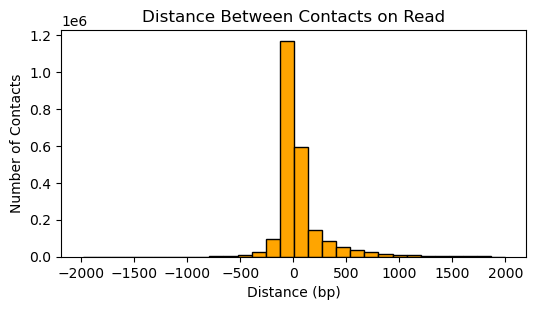

In [5]:
# look at distribution of distances between direct fragments on read

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 6, 3

tmp = df[df['contact_is_direct'] == True]

lb = -2000
ub = 2000

tmp = tmp[(tmp['contact_read_distance'] >= lb) & (tmp['contact_read_distance'] <= ub) ]

plt.hist(tmp['contact_read_distance'], edgecolor='k', bins=30, color='orange')

plt.title('Distance Between Contacts on Read')
plt.xlabel('Distance (bp)')
plt.ylabel('Number of Contacts')

# Filters

In [6]:
# drop clique expanion products
print(f"{df.shape=}")
df = filters.adjacentContactFilter(df)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

print()
res = pcu.getSummary(df)
pcu.printSummary(res)

df.shape=(10525887, 38)
df.shape=(2316535, 38)
currentRecords/totalRecords=0.2201

Total Reads 557134 (1.000)
Singletons 145909 (0.262)
Pairs 105723 (0.190)
Multiway 305502 (0.548)
-- -- --
Total Contacts 2316535.0 (1.000)
cis Contacts 1903661.0 (0.822)
trans Contacts 412874.0 (0.178)
Cis/Trans Ratio 4.610755339401367 (0.000)
-- -- --
Total Contacts 2316535 (1.000)
Intra- Contacts 1903661 (0.822)
Inter- Contacts 412874 (0.178)
-- -- --
Total Contacts 2316535 (1.000)
Direct Contacts 2316535 (1.000)
Indirect Contacts 0 (0.000)


In [7]:
# break

In [8]:
# remove read-level self-loops
print(f"{df.shape=}")
df = filters.selfLoopFilter(df)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

df.shape=(2316535, 38)
df.shape=(1615559, 38)
currentRecords/totalRecords=0.1535


mapq.shape=(3231118, 2)
mapq.shape=(967332, 2)


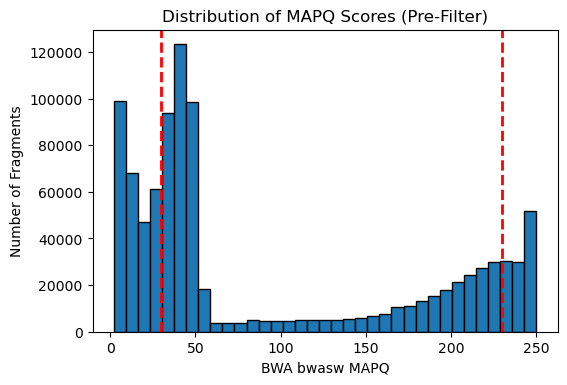

In [9]:
# add histogram of mapq scores

lb = 30 # default lower and upper bounds
ub = 230

mapq = pcu.getFragmentMAPQ(df)
print(f"{mapq.shape=}")
mapq = mapq.drop_duplicates() # drop identical fragments
print(f"{mapq.shape=}")


plt.rcParams['figure.figsize'] = 6, 4
t = plt.hist(mapq['mapq'], bins=35, edgecolor='k')

plt.title('Distribution of MAPQ Scores (Pre-Filter)')
plt.xlabel('BWA bwasw MAPQ')
plt.ylabel('Number of Fragments')


plt.axvline(x=lb, ls="--", c='r', lw=2)
plt.axvline(x=ub, ls="--", c='r', lw=2)

In [10]:
# mapping quality filter
print(f"{df.shape=}")
df = filters.mapQFilter(df, lowerBound=lb, upperBound=ub) # from above 
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

print()
res = pcu.getSummary(df)
pcu.printSummary(res)

df.shape=(1615559, 38)
df.shape=(560381, 38)
currentRecords/totalRecords=0.0532

Total Reads 277076 (1.000)
Singletons 143556 (0.518)
Pairs 66419 (0.240)
Multiway 67101 (0.242)
-- -- --
Total Contacts 560381.0 (1.000)
cis Contacts 439777.0 (0.785)
trans Contacts 120604.0 (0.215)
Cis/Trans Ratio 3.6464545122881495 (0.000)
-- -- --
Total Contacts 560381 (1.000)
Intra- Contacts 439777 (0.785)
Inter- Contacts 120604 (0.215)
-- -- --
Total Contacts 560381 (1.000)
Direct Contacts 560381 (1.000)
Indirect Contacts 0 (0.000)


mapq.shape=(1120762, 2)
mapq.shape=(456761, 2)


Text(0, 0.5, 'Number of Fragments')

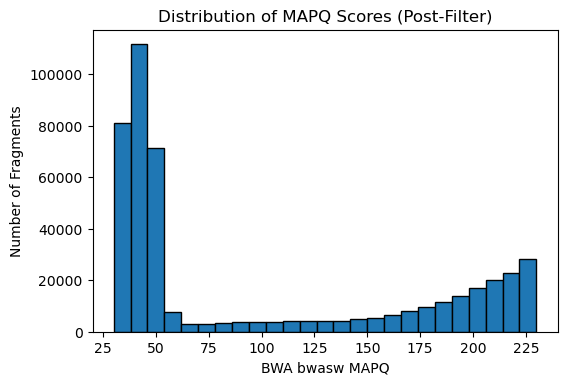

In [11]:
mapq = pcu.getFragmentMAPQ(df)
print(f"{mapq.shape=}")
mapq = mapq.drop_duplicates()
print(f"{mapq.shape=}")


plt.rcParams['figure.figsize'] = 6, 4
t = plt.hist(mapq['mapq'], bins=25, edgecolor='k')

plt.title('Distribution of MAPQ Scores (Post-Filter)')
plt.xlabel('BWA bwasw MAPQ')
plt.ylabel('Number of Fragments')

In [12]:
# a filter for direct contacts too far away on the read
print(f"{df.shape=}")
df = filters.distalContactFilter(df)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

df.shape=(560381, 38)
df.shape=(552334, 38)
currentRecords/totalRecords=0.0525


In [13]:
# cis contacts within 1kb ON THE REFERENCE are assumed to be amplification bias
print(f"{df.shape=}")
df = filters.closeContactFilter(df)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

df.shape=(552334, 38)
df.shape=(372304, 38)
currentRecords/totalRecords=0.0354


In [14]:
# filter duplicate contacts: does this make sense? the contact with the higest average MAPQ is retained
print(f"{df.shape=}")
df = filters.duplicateContactFilter(df, retain=1)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

print()
res = pcu.getSummary(df)
pcu.printSummary(res)

df.shape=(372304, 38)
df.shape=(170881, 40)
currentRecords/totalRecords=0.0162

Total Reads 111826 (1.000)
Singletons 75664 (0.677)
Pairs 22734 (0.203)
Multiway 13428 (0.120)
-- -- --
Total Contacts 170881.0 (1.000)
cis Contacts 74709.0 (0.437)
trans Contacts 96172.0 (0.563)
Cis/Trans Ratio 0.7768269350746579 (0.000)
-- -- --
Total Contacts 170881 (1.000)
Intra- Contacts 74709 (0.437)
Inter- Contacts 96172 (0.563)
-- -- --
Total Contacts 170881 (1.000)
Direct Contacts 170881 (1.000)
Indirect Contacts 0 (0.000)


In [15]:
# for single cells, there can be at most 2 copies of any sequence (ligation product)
print(f"{df.shape=}")
df = filters.ligationProductFilter(df, nProducts=4, verbose=False)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

# quick check of the above
testCounts = filters.getFragmentCounts(df)
print(f"{testCounts.most_common(1)=}")

print()
res = pcu.getSummary(df)
pcu.printSummary(res)

df.shape=(170881, 40)
df.shape=(55111, 44)
currentRecords/totalRecords=0.0052
testCounts.most_common(1)=[(11612264, 7)]

Total Reads 39884 (1.000)
Singletons 29358 (0.736)
Pairs 7352 (0.184)
Multiway 3174 (0.080)
-- -- --
Total Contacts 55111.0 (1.000)
cis Contacts 43650.0 (0.792)
trans Contacts 11461.0 (0.208)
Cis/Trans Ratio 3.8085681877672104 (0.000)
-- -- --
Total Contacts 55111 (1.000)
Intra- Contacts 43650 (0.792)
Inter- Contacts 11461 (0.208)
-- -- --
Total Contacts 55111 (1.000)
Direct Contacts 55111 (1.000)
Indirect Contacts 0 (0.000)


In [16]:
# break

# Added Features

Text(0, 0.5, 'Number of Reads')

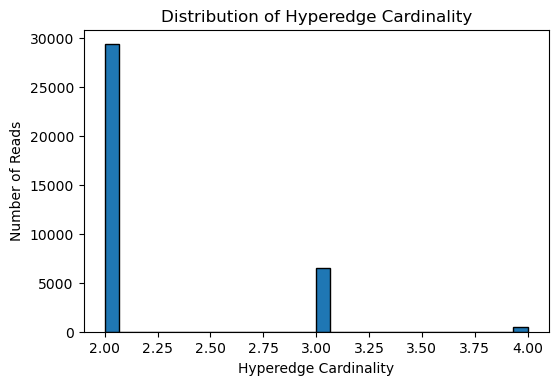

In [17]:
# add the cardinality of the hyperedge
df['edgeOrder'] = df.groupby(["read_name"])["align2_fragment_id"].transform("count")

# map read count back to concatemer multicplitity
orderDict = {}
for i in range(df['edgeOrder'].max()):
    orderDict[math.comb(i, 2)] = i
    
df['hyperedgeOrder'] = df['edgeOrder'].map(orderDict)

res = plt.hist(df['hyperedgeOrder'], edgecolor='k', bins=30)
# res = plt.hist(df['edgeOrder'], edgecolor='k', bins=30, color='orange')
plt.title('Distribution of Hyperedge Cardinality')
plt.xlabel('Hyperedge Cardinality')
plt.ylabel('Number of Reads')

Text(0, 0.5, 'Number of Reads')

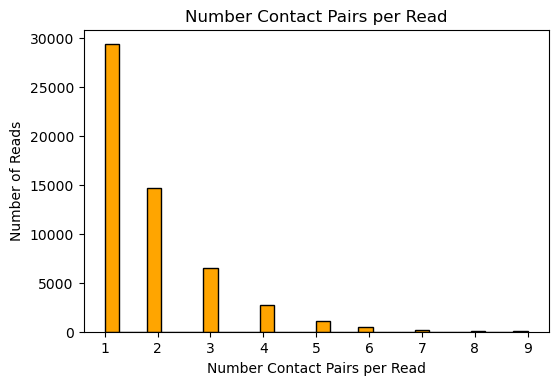

In [18]:
# add the cardinality of the read
res = plt.hist(df['edgeOrder'], edgecolor='k', bins=30, color='orange')
# res = plt.hist(df['edgeOrder'], edgecolor='k', bins=30, color='orange')
plt.title('Number Contact Pairs per Read')
plt.xlabel('Number Contact Pairs per Read')
plt.ylabel('Number of Reads')

In [19]:
# break

df['hyperedgeOrder'].median()=2.0
percOneWay=53.270671916677244
percPairs=26.68069895302208
percHyper=8.30687158643465


Text(0.5, 1.0, 'scPore-C')

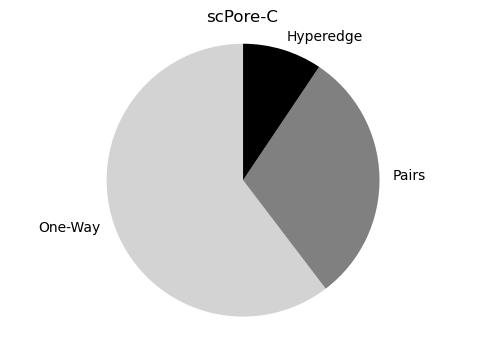

In [20]:
percOneWay = (np.sum(np.where(df['edgeOrder'] == 1, 1, 0)) / len(df)) * 100
percPairs = (np.sum(np.where(df['edgeOrder'] == 2, 1, 0)) / len(df)) * 100
percHyper = (np.sum(np.where(df['edgeOrder'] > 3, 1, 0)) / len(df)) * 100

print(f"{df['hyperedgeOrder'].median()=}")

print(f"{percOneWay=}")
print(f"{percPairs=}")
print(f"{percHyper=}")

labels = ['One-Way', 'Pairs', 'Hyperedge']

sizes = [percOneWay, percPairs, percHyper]
plt.rcParams['figure.facecolor'] = 'w'

fig1, ax1 = plt.subplots()
ax1.pie(sizes, 
        labels=labels, 
        startangle=90,
        colors=['lightgrey', 'grey', 'k'])

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('scPore-C')

# Mapping to the Assembly

In [21]:
assembly = pd.read_csv("GRCm39_Assembly.txt")
assembly['chromEnd'] = assembly['Total length'].cumsum()
assembly['chromStart'] = assembly['chromEnd'] - assembly['Total length']
assembly['RefSeq accession'] = assembly['RefSeq accession'].str.strip()
assembly

,Chromosome,Total length,GenBank accession,RefSeq accession,chromEnd,chromStart
0,1,195154279,CM000994.3,NC_000067.7,195154279,0
1,2,181755017,CM000995.3,NC_000068.8,376909296,195154279
2,3,159745316,CM000996.3,NC_000069.7,536654612,376909296
3,4,156860686,CM000997.3,NC_000070.7,693515298,536654612
4,5,151758149,CM000998.3,NC_000071.7,845273447,693515298
5,6,149588044,CM000999.3,NC_000072.7,994861491,845273447
6,7,144995196,CM001000.3,NC_000073.7,1139856687,994861491
7,8,130127694,CM001001.3,NC_000074.7,1269984381,1139856687
8,9,124359700,CM001002.3,NC_000075.7,1394344081,1269984381
9,10,130530862,CM001003.3,NC_000076.7,1524874943,1394344081


In [22]:
# filter out non-chromosomal sections of the genome
print(f"{df.shape=}")
df = filters.chromosomalFilter(df, assembly)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

df.shape=(55111, 46)
df.shape=(55040, 47)
currentRecords/totalRecords=0.0052


In [23]:
# remove y chrom (these are male mice)
print(f"{df.shape=}")
df = filters.removeYChrom(df)
currentRecords = df.shape[0]
print(f"{df.shape=}")
print(f"{currentRecords/totalRecords=:.4f}")

df.shape=(55040, 47)
df.shape=(55034, 47)
currentRecords/totalRecords=0.0052


In [24]:
# add the chromosome starting location to each fragment

chromosomeStart = pd.Series(assembly['chromStart'].values, index=assembly['RefSeq accession'].str.strip()).to_dict()

df['align1_chrom_start'] = df['align1_chrom'].astype(str).map(chromosomeStart)
df['align2_chrom_start'] = df['align2_chrom'].astype(str).map(chromosomeStart)

# create genomewide starting position of fragments
df['align1_absolute_position'] = df['align1_fragment_start'] + df['align1_chrom_start']
df['align2_absolute_position'] = df['align2_fragment_start'] + df['align2_chrom_start']

print('done.')

done.


In [25]:
res = pcu.getSummary(df)
pcu.printSummary(res)

Total Reads 39829 (1.000)
Singletons 29318 (0.736)
Pairs 7341 (0.184)
Multiway 3170 (0.080)
-- -- --
Total Contacts 55034.0 (1.000)
cis Contacts 43629.0 (0.793)
trans Contacts 11405.0 (0.207)
Cis/Trans Ratio 3.8254274441034632 (0.000)
-- -- --
Total Contacts 55034 (1.000)
Intra- Contacts 43629 (0.793)
Inter- Contacts 11405 (0.207)
-- -- --
Total Contacts 55034 (1.000)
Direct Contacts 55034 (1.000)
Indirect Contacts 0 (0.000)


In [26]:
# break

SyntaxError: 'break' outside loop (<ipython-input-26-6aaf1f276005>, line 1)

# Binning 

In [27]:
# adding genome-wide binning

def getBins(length, scale):
    """ Return bin IDS for a given range of bp """
    n = int(np.ceil(length / scale))    
    bins = [scale]
    for i in range(n-1):
        next_bin = bins[i] + scale
        bins.append(next_bin)
    return np.array(bins)


def returnBin(position, bins):
    idx = np.min(np.argwhere(bins > position))
    return idx - 1 


def wholeGenomeBinData(df, bins, label):
    df[f'align1_{label}Bin'] = df['align1_absolute_position'].apply(lambda x: returnBin(x, bins))
    df[f'align2_{label}Bin'] = df['align2_absolute_position'].apply(lambda x: returnBin(x, bins))
    return df


def genomeWideBins(df, assembly, scale=1000000):
    totalLength = assembly['chromEnd'].max()
    bins = getBins(totalLength, scale)
    
    df = wholeGenomeBinData(df, bins, label='genome')
    return df, bins
    
    
scale=1000000 # 1MB
# scale=10000000 # 10MB
df, genomeBins = genomeWideBins(df, assembly, scale)
print('genome-wide binning done.')

genome-wide binning done.


In [28]:
# get the binned chromosome positions
chromBins = {}

for idx, row in assembly.iterrows():
    chromBin = returnBin(row['chromEnd'], genomeBins)
    chromBins[row['Chromosome']] = chromBin
    
del chromBins['Y']

print('done.')                      

done.


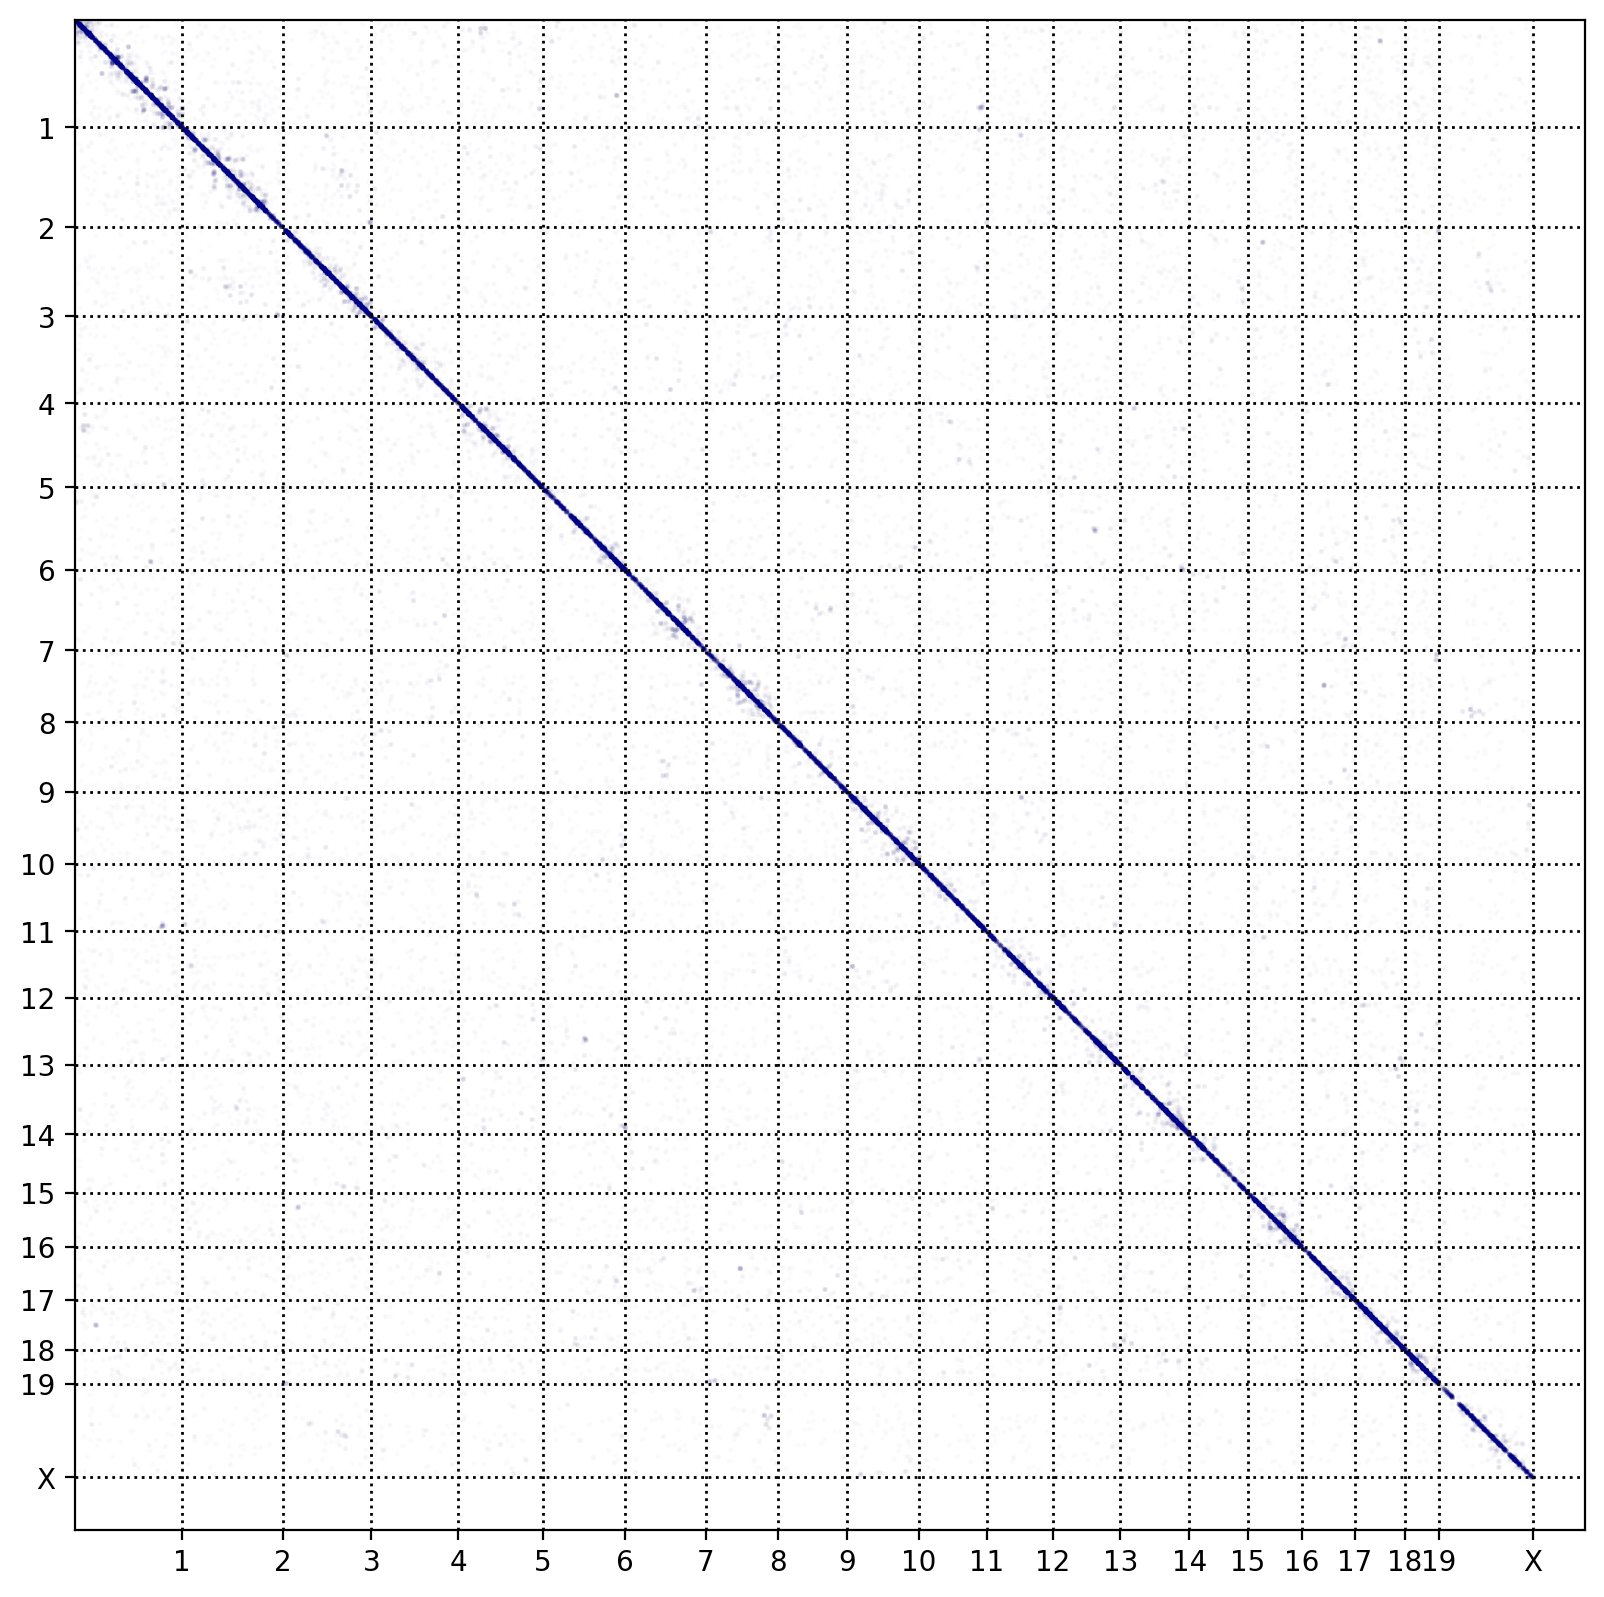

In [29]:
# plot the genome-wide conformation

def genomewidePlot(df, alpha, size, genomeBins, chromBins):
    plt.scatter(df['align1_genomeBin'], 
                df['align2_genomeBin'], 
                marker='s', 
                s=size, 
                alpha=alpha, 
                c='darkblue')

    plt.scatter(df['align2_genomeBin'], 
                df['align1_genomeBin'], 
                marker='s', 
                s=size, 
                alpha=alpha, 
                c='darkblue')


    plt.xlim(0, len(genomeBins) )
    plt.ylim(len(genomeBins), 0)
    ax = plt.gca() # Get current axes object
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.gca().set_aspect('equal', adjustable='box')

    for k, v in chromBins.items():
        plt.axvline(x=v, lw=1, c='k', ls=':')
        plt.axhline(y=v, lw=1, c='k', ls=':')

    plt.xticks(list(chromBins.values()))
    ax.set_xticklabels(list(chromBins.keys()))

    plt.yticks(list(chromBins.values()))
    ax.set_yticklabels(list(chromBins.keys()))
    

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10
alpha = 0.05
size = 0.5

genomewidePlot(df, alpha, size, genomeBins, chromBins)


In [ ]:
# break

# KEEP THIS

In [ ]:
"""

COOPER: KEEP THIS

"""
# grped = df.groupby(['align1_genomeBin', 'align2_genomeBin'])['read_name'].count().reset_index() # NOTE: not counting unique here

# binBin = grped.pivot(*grped)
# binBin = np.log(binBin) # log scale
# binBin = binBin.fillna(0)

# missing = np.setxor1d(binBin.index, binBin.columns)

# # keep only symmetric entries
# binBin = binBin.drop(index=missing, errors='ignore')
# binBin = binBin.drop(missing, axis=1, errors='ignore')

# # symmetrize
# binBin = binBin + binBin.T - np.diag(np.diag(binBin))

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 15, 15

# sns.heatmap(binBin, 
#             cmap='viridis',
#             square=True,
#                 cbar_kws={'fraction':0.046, 'pad':0.04})


In [ ]:
# @todo interchromosomal unique reads and effects of clique expansion 

# Inter Chromosomal Contact Analysis

totalContacts=55034
numInter=11405
numInter/totalContacts=0.207


Text(0, 0.5, 'Number of Reads')

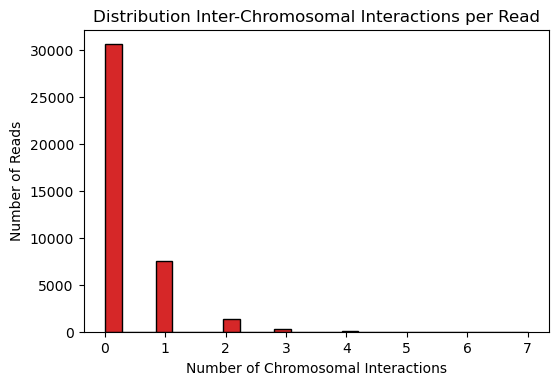

In [33]:
df['inter_edge'] = np.where(df['align1_chrom'] != df['align2_chrom'],1, 0)

totalContacts = len(df)
numInter = np.sum(df['inter_edge'])

print(f"{totalContacts=}")
print(f"{numInter=}")
print(f"{numInter/totalContacts=:.3f}")


grped = df.groupby('read_name').agg(
        numInterContacts=('inter_edge', np.sum),
        totalContacts=('align1_fragment_id', 'count')
).reset_index()

grped['percContactInter'] = grped['numInterContacts'] / grped['totalContacts']

grped.head()


plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['figure.dpi'] = 100
t = plt.hist(grped['numInterContacts'], bins=25, edgecolor='k', color='C3')

ax = plt.gca()
# ax.set_yscale('log')

plt.title('Distribution Inter-Chromosomal Interactions per Read')
plt.xlabel('Number of Chromosomal Interactions')
plt.ylabel('Number of Reads')

Text(145.72222222222223, 0.5, '')

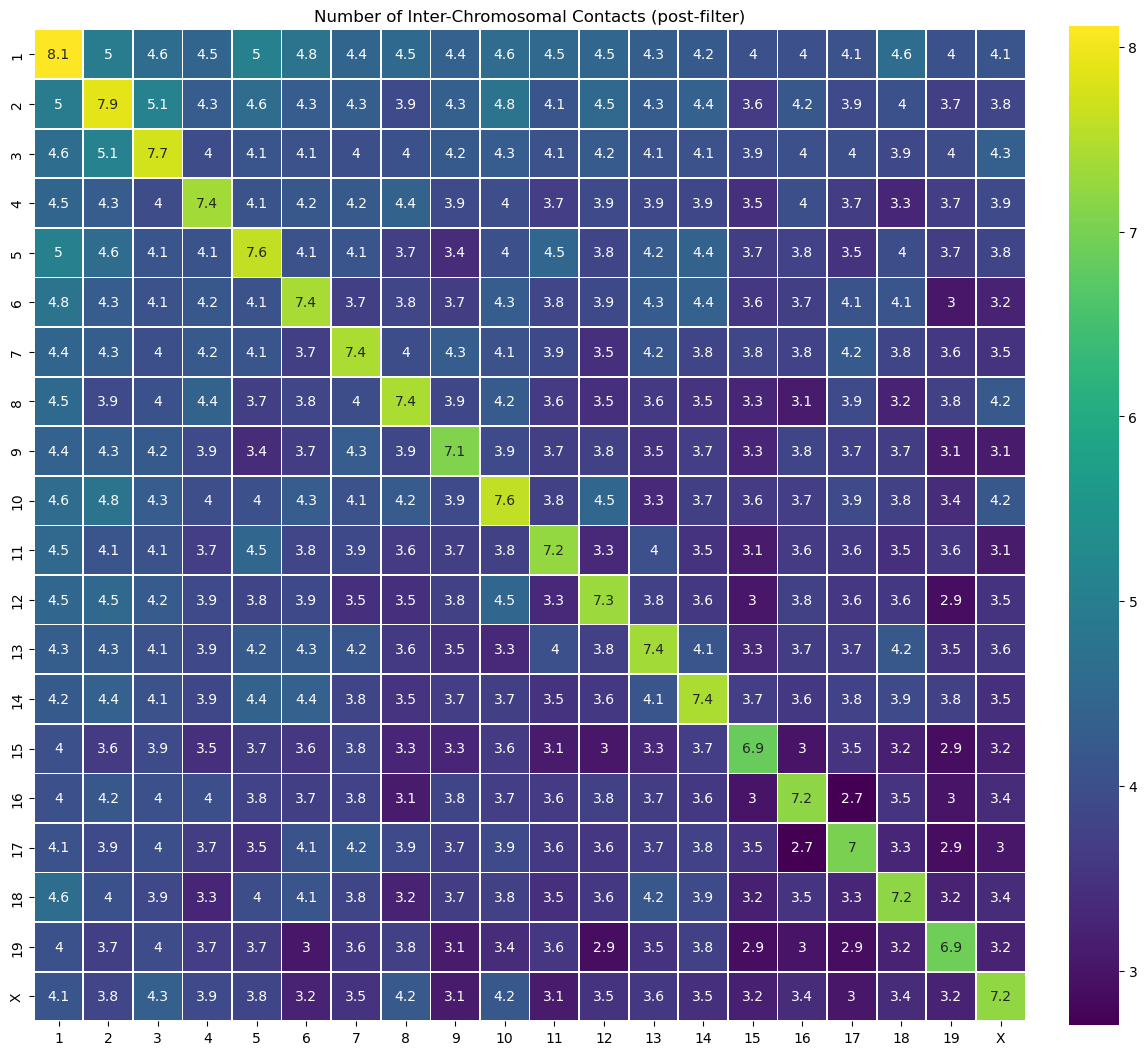

In [36]:
grped = df.groupby(['align1_chrom', 'align2_chrom'])['read_name'].nunique().reset_index()

refseq2Chrom = pd.Series(assembly['Chromosome'].values, index=assembly['RefSeq accession'].str.strip()).to_dict()

grped['align1_chromName'] = grped['align1_chrom'].astype(str).map(refseq2Chrom)
grped['align2_chromName'] = grped['align2_chrom'].astype(str).map(refseq2Chrom)

# drop zero-value counts (because the chrom is a category data type)

grped = grped[grped['read_name'] > 0].reset_index()

chromChrom = grped.pivot(index='align1_chromName', columns=['align2_chromName'])['read_name']

chromChrom = np.log(chromChrom) # log scale
chromChrom = chromChrom.fillna(0)


# sort the chromosomes
chromOrder = list(refseq2Chrom.values())[:-1]
chromChrom = chromChrom[chromOrder]
chromChrom = chromChrom.reindex(chromOrder)

# make symmetric
chromChrom = chromChrom + chromChrom.T - np.diag(np.diag(chromChrom))

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 14, 14
        
sns.heatmap(chromChrom, 
            annot=True, 
            fmt='.2g',
            cmap='viridis',
            linewidths=.5,
            square=True,
            cbar_kws={'fraction':0.046, 'pad':0.04})
        
plt.title('Number of Inter-Chromosomal Contacts (post-filter)')
plt.xlabel('')
plt.ylabel('')

In [ ]:
break

# Chromosome Selection

In [30]:
# subset the data to a single chromosome
chomosome = 2
chrom_assembly = assembly.loc[assembly['Chromosome'] == str(chomosome)]
refseq = chrom_assembly['RefSeq accession'].tolist()[0].strip()
chromLength = chrom_assembly['Total length'].tolist()[0]

def filterChomosome(df, refseq):
    mask = (df['align1_chrom'] == refseq) & (df['align2_chrom'] == refseq)
    df = df[mask].reset_index(drop=True)
    return df
    
    
chr2 = filterChomosome(df, refseq)
print(f"{chr2.shape=}")

chr2.shape=(3562, 53)


In [31]:
# bin data within a chromosome
# scale = 100000 #100kb scale
scale = 1000000 # 1mb scale

def chromosomeBinData(df, bins, label):
    df[f'align1_{label}Bin'] = df['align1_fragment_start'].apply(lambda x: returnBin(x, bins))
    df[f'align2_{label}Bin'] = df['align2_fragment_start'].apply(lambda x: returnBin(x, bins))
    return df


bins = getBins(chromLength, scale)
print(f"{len(bins)=}")


chr21mb = chromosomeBinData(chr2, bins, label='chrom2')
print('done.')

len(bins)=182
done.


# Construct pseudo Hi-C Matrices

In [ ]:
def constructHiCSingleChromosome(df, log=True, binary=False):
    grped = df.groupby(['align1_chrom2Bin', 'align2_chrom2Bin'])['read_name'].count().reset_index() # NOTE: not counting unique here

    binBin = grped.pivot(*grped)
    if log:
        binBin = np.log(binBin) # log scale

    binBin = binBin.fillna(0)

    missing = np.setxor1d(binBin.index, binBin.columns)

    # keep only symmetric entries
    binBin = binBin.drop(index=missing, errors='ignore')
    binBin = binBin.drop(missing, axis=1, errors='ignore')

    # symmetrize
    binBin = binBin + binBin.T - np.diag(np.diag(binBin))
        
    if binary:
        binBin = np.where(binBin > 0, 1, 0)
    return binBin

A = constructHiCSingleChromosome(chr2)
print(f"{A.shape=}")

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 10, 10
        
sns.heatmap(A, 
            cmap='viridis',
            square=True,
            cbar_kws={'fraction':0.046, 'pad':0.04})
        
# plt.title('Number of Intra-Chromosomal Contacts (post-filter)')
# plt.xlabel('')
# plt.ylabel('')
plt.axis(False)

# Single Chromosome Plotting

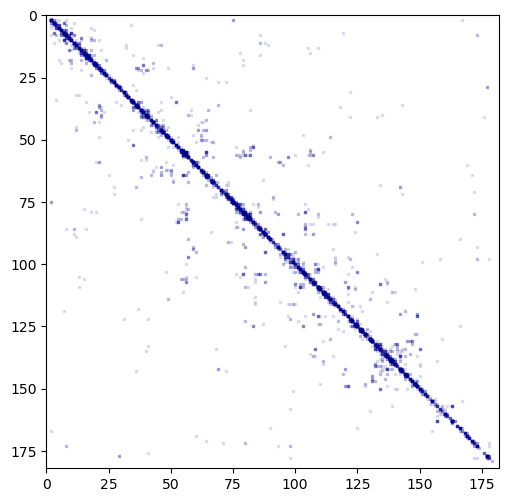

In [32]:
def plotHiCscatter(df, bin1, bin2, params):
     
    plt.rcParams['figure.dpi'] = params['figdpi']
    plt.rcParams['figure.figsize'] = params['figsize']
    
    plt.scatter(df[bin1], df[bin2], 
                marker='s', 
                s=params['size'], 
                alpha=params['alpha'], 
                c=params['color'])


    plt.scatter(df[bin2], 
                df[bin1], 
                marker='s', 
                s=params['size'], 
                alpha=params['alpha'], 
                c=params['color'])

    plt.xlim(0, len(bins))
    plt.ylim(len(bins), 0)
    ax = plt.gca() # Get current axes object
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.gca().set_aspect('equal', adjustable='box')

    
params = {
    'figdpi' : 100,
    'figsize' : (6,6),
    'size' : 1,
    'alpha' : 0.1,
#     'color' : np.log(chr2['edgeOrder']),
    'color' : 'darkblue',
}

# plt.set_cmap('gnuplot_r')
plotHiCscatter(chr2, bin1='align1_chrom2Bin', bin2='align2_chrom2Bin', params=params)


# clb = plt.colorbar(fraction=0.046, pad=0.04, ticks=[np.min(np.log(chr2['edgeOrder'])), np.max(np.log(chr2['edgeOrder']))])
# clb.ax.set_yticklabels(['low', 'high'])
# clb.ax.set_title('Contact Order',fontsize=8)

In [ ]:





alpha = 0.1
size = 1


plt.scatter(chr2['align1_chrom2Bin'], 
            chr2['align2_chrom2Bin'], 
            marker='s', 
            s=size, 
            alpha=alpha, 
            c='darkblue')